# Healthy and Bleached Corals Image Classification using MobileNet

In [9]:
!pip install transformers torch torchvision torchaudio


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\krain\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

A custom Dataset class is created to load the coral images from the file paths HEALTHY_IMAGES_DIR and BLEACHED_IMAGES_DIR.
The subfolders contain images of healthy and bleached corals.

The dataset used is from Kaggle: https://www.kaggle.com/datasets/vencerlanz09/healthy-and-bleached-corals-image-classification/data

Dataset Details:
+ Total images: 923
+ Image categories: 2
    + Healthy corals: 438 images
    + Bleached corals: 485 images
+ Image format: JPEG
+ Image size: Maximum 300 px for either width or height, whichever is higher

After loading the images the dta is splitted into training and testing sets.

In [11]:
class CoralDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [12]:
HEALTHY_IMAGES_DIR = "data/healthy_corals"
healthy_image_paths = [os.path.join(HEALTHY_IMAGES_DIR, img) for img in os.listdir(HEALTHY_IMAGES_DIR) if os.path.isfile(os.path.join(HEALTHY_IMAGES_DIR, img))]
BLEACHED_IMAGES_DIR = "data/bleached_corals"
bleached_image_paths = [os.path.join(BLEACHED_IMAGES_DIR, img) for img in os.listdir(BLEACHED_IMAGES_DIR) if os.path.isfile(os.path.join(BLEACHED_IMAGES_DIR, img))]

image_paths = healthy_image_paths + bleached_image_paths
labels = [0] * len(healthy_image_paths) + [1] * len(bleached_image_paths)

# Split the data into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [13]:
# Calculate mean and standard deviation for normalization
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Temporary dataset to calculate mean and std
train_dataset_for_stats = CoralDataset(train_paths, train_labels, transform=train_transform)
train_loader_for_stats = DataLoader(train_dataset_for_stats, batch_size=40, shuffle=False, num_workers=0)

mean = 0.
std = 0.
nb_samples = 0.

for data in train_loader_for_stats:
    images, _ = data
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Calculated Mean: {mean}")
print(f"Calculated Std: {std}")

Calculated Mean: tensor([0.3119, 0.4154, 0.4176])
Calculated Std: tensor([0.1932, 0.1951, 0.2077])


Image data is preprocessed for training, to make the model more robust:
* Images are resized to 224x224 pixels, this matches the expected intput size for the MobileNet model.
* Images are converted from a PIL format to PyTorch tensor, because PyTorch models operate on tensors and not images.
* Pixel intensity values are adjusted to match the mean and standard deviation of the ImageNet dataset. MobileNet is pretrained on ImageNet and expects input data with similar statistics, otherwise the trianing migth be unstable or converge slowly

The Binary Cross Entropy loss is used as loss function, it can be used for binary classification problems, where each output is a probability between 0 and 1.
The Asam optimizer updates the model's weights to minimize the loss function. It determines how the model learns during backpropagation.

In [14]:
# Image transformations using calculated mean and std
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Create train and validation datasets
train_dataset = CoralDataset(train_paths, train_labels, transform=transform)
val_dataset = CoralDataset(val_paths, val_labels, transform=transform)

# DataLoader for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=40, shuffle=False, num_workers=0)

# Load the pretrained MobileNet model
model = AutoModelForImageClassification.from_pretrained("google/mobilenet_v2_1.0_224")

# Replace the classifier layer to output a single value for binary classification
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 1),
    nn.Sigmoid()
)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the optimizer and loss function
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

For verification an better understanding the image transformations are visualized using five random images from the training dataset.

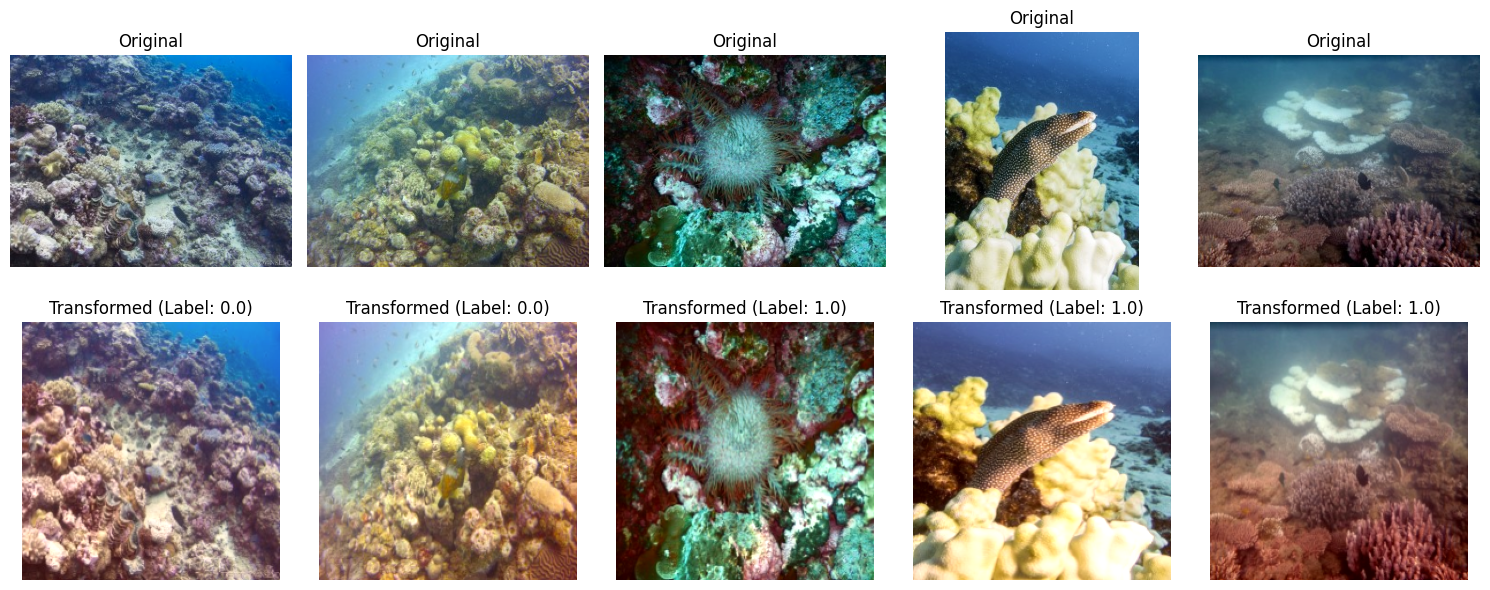

In [15]:
# Visualize original and transformed images one above the other
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns (original and transformed)


# Function to denormalize images for visualization
def denormalize(image, mean, std):
    mean = np.array(mean).reshape(1, 1, 3)
    std = np.array(std).reshape(1, 1, 3)
    image = image.numpy().transpose((1, 2, 0))  # Convert from tensor (C, H, W) to (H, W, C)
    image = std * image + mean  # Undo normalization
    image = np.clip(image, 0, 1)  # Clip values to [0, 1]
    return image


# Define mean and std (same as used in transformations)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Disable shuffling temporarily
temp_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)

# Fetch a small batch of images and labels
data_iter = iter(temp_loader)
images, labels = next(data_iter)

for i in range(5):  # Show 5 images
    # Load the original image directly using the same index
    img_path = train_paths[i]  # Ensure train_paths is accessible
    original_image = Image.open(img_path).convert('RGB')

    # Plot the original image
    axes[0, i].imshow(original_image)
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    # Plot the transformed image
    transformed_image = denormalize(images[i], mean, std)
    axes[1, i].imshow(transformed_image)
    axes[1, i].set_title(f"Transformed (Label: {labels[i].item()})")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

The model learns from training data by minimizing the loss through gradient descent.

In [16]:
# Training loop
epochs = 10
training_results = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images).logits.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits.squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # Store training results for correlation matrix
    training_results.append({'epoch': epoch + 1, 'train_loss': running_loss / len(train_loader), 'val_loss': val_loss / len(val_loader), 'val_accuracy': val_accuracy})

print("Training complete.")

KeyboardInterrupt: 

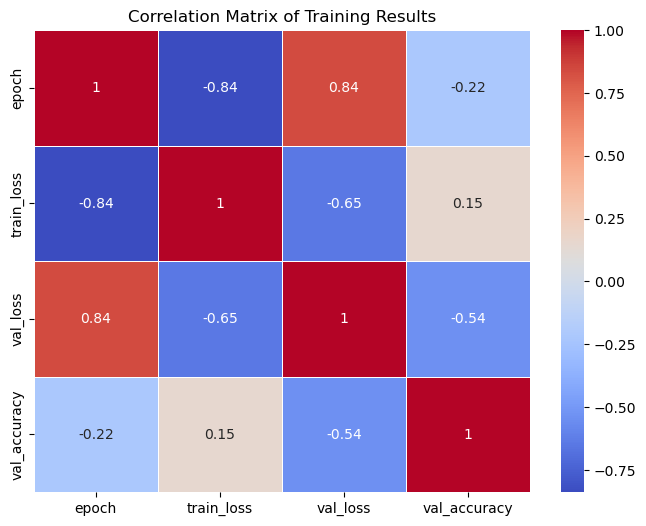

In [19]:
# Display correlation matrix for training results
results_df = pd.DataFrame(training_results)
corr_matrix = results_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Training Results")
plt.show()


Run	Batch Size	Learning Rate (LR)	Augmentation	Epochs	Why Test These Values?
1	40	0.0001	Resize, Normalize	10	Baseline values using default parameters from your current implementation.
2	60	0.00005	Resize, Normalize, Horizontal Flip	15	Larger batch size and more epochs for stable training and better convergence.
3	20	0.0002	Resize, Normalize, Rotation (15°)	10	Smaller batch size for better generalization and higher LR for faster updates.
4	40	0.0001	Resize, Normalize, Horizontal Flip + Color Jitter (Brightness, Contrast)	20	Introduces additional augmentation and extended training for robustness and potential overfitting evaluation.
Why Test These Parameters?
1. Batch Size
Why vary?
Larger batch sizes stabilize training but require more memory.
Smaller batch sizes promote generalization and can help in imbalanced datasets.
What to expect?
Smaller batch sizes might show better validation accuracy.
Larger batch sizes might improve convergence speed and training stability.
2. Learning Rate
Why vary?
The learning rate controls how much the model adjusts its weights in response to the loss.
Smaller LR values ensure precise weight updates, while larger LR values speed up convergence.
What to expect?
A lower LR (e.g., 0.00005) might benefit deeper or more complex models.
A higher LR (e.g., 0.0002) can help the model converge faster during early training.
3. Augmentation
Why vary?
Augmentation increases variability in the training data, helping the model generalize better.
Adding Horizontal Flip, Rotation, or Color Jitter can mimic real-world variations in coral images.
What to expect?
Augmentation should reduce overfitting and improve validation accuracy, especially for small datasets.
4. Epochs
Why vary?
More epochs allow the model to learn longer but increase the risk of overfitting.
Fewer epochs might miss optimal performance.
What to expect?
Longer training (e.g., 20 epochs) might refine performance when combined with strong regularization (e.g., augmentation).Here’s a **test plan for four runs** of your MobileNet-based model with different hyperparameter configurations. These variations will help you evaluate how changes in batch size, learning rate, augmentation, and epochs affect model performance.

---

### **Proposed Runs and Parameters**

| **Run** | **Batch Size** | **Learning Rate (LR)** | **Augmentation**                     | **Epochs** | **Why Test These Values?**                                                                          |
|---------|----------------|-------------------------|---------------------------------------|-------------|-----------------------------------------------------------------------------------------------------|
| **1**   | 40             | 0.0001                 | Resize, Normalize                    | 10          | Baseline values using default parameters from your current implementation.                         |
| **2**   | 60             | 0.00005                | Resize, Normalize, Horizontal Flip   | 15          | Larger batch size and more epochs for stable training and better convergence.                       |
| **3**   | 20             | 0.0002                 | Resize, Normalize, Rotation (15°)    | 10          | Smaller batch size for better generalization and higher LR for faster updates.                     |
| **4**   | 40             | 0.0001                 | Resize, Normalize, Horizontal Flip + Color Jitter (Brightness, Contrast) | 20          | Introduces additional augmentation and extended training for robustness and potential overfitting evaluation. |

---

### **Why Test These Parameters?**

#### **1. Batch Size**
- **Why vary?**
  - Larger batch sizes stabilize training but require more memory.
  - Smaller batch sizes promote generalization and can help in imbalanced datasets.
- **What to expect?**
  - Smaller batch sizes might show better validation accuracy.
  - Larger batch sizes might improve convergence speed and training stability.

#### **2. Learning Rate**
- **Why vary?**
  - The learning rate controls how much the model adjusts its weights in response to the loss.
  - Smaller LR values ensure precise weight updates, while larger LR values speed up convergence.
- **What to expect?**
  - A lower LR (e.g., `0.00005`) might benefit deeper or more complex models.
  - A higher LR (e.g., `0.0002`) can help the model converge faster during early training.

#### **3. Augmentation**
- **Why vary?**
  - Augmentation increases variability in the training data, helping the model generalize better.
  - Adding `Horizontal Flip`, `Rotation`, or `Color Jitter` can mimic real-world variations in coral images.
- **What to expect?**
  - Augmentation should reduce overfitting and improve validation accuracy, especially for small datasets.

#### **4. Epochs**
- **Why vary?**
  - More epochs allow the model to learn longer but increase the risk of overfitting.
  - Fewer epochs might miss optimal performance.
- **What to expect?**
  - Longer training (e.g., 20 epochs) might refine performance when combined with strong regularization (e.g., augmentation).

---

### **Result Table After Each Run**

| **Run** | **Batch Size** | **Learning Rate** | **Augmentation**                | **Epochs** | **Final Train Loss** | **Final Val Loss** | **Final Val Accuracy** |
|---------|----------------|-------------------|----------------------------------|------------|-----------------------|---------------------|-------------------------|
| 1       | 40             | 0.0001           | Resize, Normalize               | 10         |                       |                     |                         |
| 2       | 60             | 0.00005          | Horizontal Flip                 | 15         |                       |                     |                         |
| 3       | 20             | 0.0002           | Rotation (15°)                  | 10         |                       |                     |                         |
| 4       | 40             | 0.0001           | Horizontal Flip + Color Jitter  | 20         |                       |                     |                         |
